## 1. 사용할 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm 
from konlpy.tag import Okt
import itertools
from collections import Counter
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
import gensim
from gensim import models
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

In [2]:
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/H2GTRE.ttf").get_name()
rc('font', family=font_name)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. 데이터 불러오기

In [3]:
data = pd.read_excel('preprocessed수정본.xlsx', sheet_name = '택시')
data.head()

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reviewId     userName  \
0  ac0fbabd-8ee3-4819-81fb-b3ffa8a296dd          김정선   
1  1e723c87-9a05-49d5-aa2f-303adeaea3bf          박블리   
2  6d247505-e723-40cf-9fad-7cde6806082c       강대한애국당   
3  19be772b-c5c0-404b-939a-6bf8bd9b5578  Gangmin Kim   
4  d43eaff4-e949-4436-960f-5eb99026dd81          ᄉᄃᄒ   

                                             content  \
0  카카오블루를 부르는 이유는 택시를 빨리 잡아 목적지에 빨리 도달하기 위해서인데 주변...   
1                                            좋은어플이에요   
2  ㅌ66 ㅣ기4ㄴㄱㄴㄱ#2-+`1+-+!Qwzwzasqzaㅣㅇ비비zw1ssQㅣㅋㅋ1a...   
3  카카오는 왜 기업이 독점을 하면서 서비스가 항상 밥찌꺼기같은지 모르겠네요 왜 자꾸 ...   
4                                               친잘하심   

                                        preprocessed          at  score  
0  카카오 블루 이유 택시 목적지 도달 주변 블루 없다 손님 하차 예정 블루 배치 금방...  2023-05-03      1  
1                                              좋다 어플  2023-05-03      5  
2                                                 비비  2023-05-03      3  
3  카카오 기업 독점 서비스 항상 찌꺼기 같다 자꾸 안내 야무지다 독점 다르다 택시 없...  2023-05-03      1  
4                                                NaN  2023-05-02      5

## 3. 데이터 전처리

### (1) 불용어 정의

In [4]:
# 불용어 리스트 생성(형용사)
stopwords = ['대한', '있다', '없다', '아니다', '같다']

stopwords2 = ''
f = open("stopwords(2).txt", 'r')
line = f.readline()
stopwords2 = stopwords2 + line
f.close()
stopwords2 = stopwords2.split(',')

stopwords = stopwords + stopwords2

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (2) Replace Words

In [5]:
f = open("replacing.txt", 'r', encoding = 'utf-8')
line = f.readlines()
line = [l.replace('\n','') for l in line]
line = [l.split('=') for l in line]
line[:3]

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['기다렸는데', '기다리다'], ['늦게오고', '늦다'], ['늦게 오고', '늦다']]

In [6]:
def Word_transform(Text, word, to_word):
    Text = str(Text).replace(word,to_word)
    return Text

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
for i in range(len(line)):
    data['content'] = [Word_transform(txt, line[i][0], line[i][1]) for txt in data['content']]    

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (3) Tokenizer 정의 (명사, 동사, 형용사)

In [8]:
def change_words(word, word1, word2):
    if word == word1:
        return word2
    else:
        return word

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
okt = Okt()
def my_tokenizer(doc):
    tokens = [token for token, pos in okt.pos(doc, norm=True, stem=True) if pos in ['Noun', 'Adjective', 'Verb']] # 토큰화, 명사만 출력
    tokens = [word for word in tokens if (word not in stopwords)] # 불용어 제거
    tokens = [change_words(word, '딴', '다른') for word in tokens]
    tokens = [change_words(word, '아치', '양아치') for word in tokens]
    tokens = [change_words(word, '갑', '갑질') for word in tokens]
    tokens = [change_words(word, '퀵', '퀵서비스') for word in tokens]
    tokens = [word for word in tokens if (len(word) > 1)]# 1글자 제외
    return tokens

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (4) Token 생성

In [10]:
Token = [my_tokenizer(sentence) for sentence in tqdm(data['content'])]

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████| 52373/52373 [04:15<00:00, 205.07it/s]


### (5) 단어 빈도 수 및 전처리 결과 저장

In [11]:
def word_frequency(Token):
    flatten_tokens = list(itertools.chain(*Token))
    token_count = Counter(flatten_tokens)
    word_count = pd.DataFrame.from_dict(token_count, orient='index').reset_index()
    word_count.columns = ['Word', 'Frequency']
    word_count = word_count.sort_values(by = 'Frequency', ascending = False).reset_index(drop = True)
    return word_count

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
sentences = [" ".join(tok) for tok in Token]
data['preprocessed'] = sentences

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
word_count = word_frequency(Token)
word_count.head(20)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word  Frequency
0     택시      22333
1     좋다      16190
2     기사      12547
3    카카오       6924
4    잡히다       5385
5     이용       4842
6    편하다       4642
7    부르다       3927
8     호출       3771
9     위치       3757
10    취소       3658
11    자다       3231
12    어플       3070
13    사용       2887
14    잡다       2884
15  편리하다       2855
16    거리       2449
17    쓰다       2391
18   해주다       2384
19    결제       2339

In [14]:
data.loc[:, ['reviewId','userName','content','preprocessed','at', 'score']].to_excel('preprocessed.xlsx', index = False)
word_count.to_csv('word_count.csv', index = False, encoding = 'euc-kr')

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. 토픽 분석

In [15]:
id2word=corpora.Dictionary(Token)
id2word.filter_extremes(no_below = 3) #3회 이하로 등장한 단어는 삭제
texts = Token
corpus=[id2word.doc2bow(text) for text in texts]

os.makedirs('./토픽분석', exist_ok = True)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (1) 적절한 토픽 개수 선정

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.savefig('./토픽분석/토픽개수선정.png')
    plt.show()
    
    return model_list, coherence_values

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


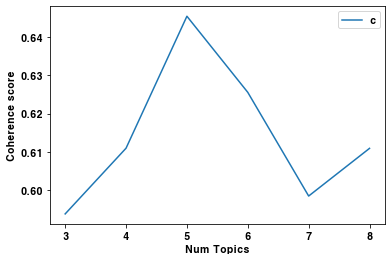

In [17]:
start_topic_num = 3
end_topic_num = 8
step = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start_topic_num, limit=end_topic_num+1, step=step)

In [18]:
best_topic_num = range(start_topic_num, end_topic_num+1, step)[coherence_values.index(max(coherence_values))]
print("Best topic number: {}".format(best_topic_num))

Best topic number: 5


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (2) 최적의 토픽 개수에 대해서 토픽별 단어 저장

In [19]:
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=8) 
topics

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.130*"기사" + 0.056*"택시" + 0.036*"비용" + 0.022*"친절하다" + 0.014*"거부" + 0.014*"많다" + 0.013*"승차" + 0.012*"부르다"'),
 (1,
  '0.184*"택시" + 0.045*"부르다" + 0.044*"카카오" + 0.027*"기사" + 0.027*"잡히다" + 0.021*"거리" + 0.019*"잡다" + 0.017*"기다리다"'),
 (2,
  '0.044*"기사" + 0.032*"택시" + 0.025*"카카오" + 0.021*"취소" + 0.019*"이용" + 0.013*"신고" + 0.012*"전화" + 0.012*"부르다"'),
 (3,
  '0.314*"좋다" + 0.084*"편하다" + 0.047*"편리하다" + 0.045*"이용" + 0.038*"최고" + 0.029*"자다" + 0.027*"빠르다" + 0.021*"사용"'),
 (4,
  '0.047*"위치" + 0.025*"네비게이션" + 0.025*"기사" + 0.022*"택시" + 0.020*"뜨다" + 0.019*"도착" + 0.015*"출발" + 0.014*"번호"')]

In [20]:
topic_words = dict()

for i in range(best_topic_num):
    words = [word for (word, prob) in best_model.show_topic(i, 20)]
    topic_words['Topic_' + str(i + 1)] = words
    
topic_words = pd.DataFrame(topic_words)

os.makedirs('./토픽분석', exist_ok = True)

topic_words.to_excel(os.path.join('./토픽분석', 'Topic Words.xlsx'), index = False)
topic_words.head(10)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_1 Topic_2 Topic_3 Topic_4 Topic_5
0      기사      택시      기사      좋다      위치
1      택시     부르다      택시     편하다   네비게이션
2      비용     카카오     카카오    편리하다      기사
3    친절하다      기사      취소      이용      택시
4      거부     잡히다      이용      최고      뜨다
5      많다      거리      신고      자다      도착
6      승차      잡다      전화     빠르다      출발
7     부르다    기다리다     부르다      사용      번호
8     들이다     가깝다    유용하다    친절하다      설정
9      평가      호출      요금      아주     해주다

### (3) 토픽 모델링 시각화

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, os.path.join('./토픽분석', 'Topic Plot.html'))

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\user\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
